## 整理与总结：  
### 一、该脚本学习了：  
①搭建生成式对抗网络：  
判别器部分：使用连续的Conv-LeakyRelu-Dropout结构，（不使用maxpooling而用strides=2卷积代替）逐渐将图像维度降到1，最后通过sigmoid输出判别概率  
生成器部分：首先将输入的100维向量通过Dense扩充至7x7x256，然后BN,LeakyRelu,reshape为卷积层输入形式并Dropout，通过连续的       Upsampling2D-Conv2D-BN-LeakyRelu将维度扩充至28,28同时深度减小为1，最后也通过sigmoid输出  

数据集准备：Z:随机噪声数据集；real:真实图像数据集；fake:生成图像数据集：通过generator.predict(z)得到   

生成对抗网络模型搭建：首先利用判别器建立model_D,在{  [real_batch+fake_batch],[real-label+fake_label]  }上训练model_D    
然后在{Z_batch,"1"-label}上freeze model_D,同时model_A  

②灵活的keras model使用方式。在第一步训练阶段，要把generator当做一个已知函数来训练D,由于keras的模型在定义之后自动初始化，可以直接用net_generator.predict(z)来得到初始fake数据集，尽管此时net_generator没有compile,更没有fit

③学习了两种方法freeze某个模型中的参数:net_D.trainable=False 或者在循环中对model.layers中的每一个元素设置trainable=False  

④学习了两种重要的可视化工具：I.如何随着训练进程逐渐绘制loss或acc曲线（要结合每次迭代model.fit返回的[loss,acc]状态）. II.使用Ipython.display.imageio读取并生成动态图，并显示在notebook上  

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

### 二、要注意的细节：  
①一定要注意：不同函数如keras,tensorflow,sklearn等产生的mnist数据集形式可能不同！！！比如tensorflow产生的像素值在[0,1]之间，keras产生的是uint8类型。而将图像块送入神经网络训练之前一定要保证转换成[0,1]之间的float型:data.astype('float')/255,否则网络学习会非常崩坏

②注意结合model.summary检查模型定义的细节错误  

③keras的model在定义之后（具体而言是net.add(Conv2D)等定义之后）即已经自动初始化了，这意味着此时使用model.predict(input)可以直接得到ndarry形式的输出，而不是tensor。  

④注意在计算卷积层输出尺寸时，先看是否满足strides=1,若strides为1，padding='same'则输出尺寸不变。若strides=2,padding='same'，按照公式进行计算:  
$δ=(F-1)/2$   
$N_{out}=(N-F+2δ)/S+1$  

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

### 三、未解决的问题：  
①在定义过net_D,net_G之后，首先用net_D定义model_D，此时model_D所有参数为trainable;然后使用net_G和net_D定义model_A时首先将net_D参数设为trainable=False.但是此时由于model_D依赖net_D,通过model_D.summary()可以看到model_D的所有参数又变成了untrainable.为什么这种情况下网络仍可以对D进行更新？＝＝>keras的变量共享机制？？？  

②定义生成器部分时采用BEGAN结构，暂时还不了解。而BEGAN中涉及到转置卷积，以及转置卷积的checkboard artifact问题，和解决方法（通过正常卷积＋Upsample代替转置卷积）等知识，需要进一步深入了解


＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

实验室之一：验证keras中的model在定义之后自动进行了初始化，即可以直接用model.predict函数

In [4]:
from keras import Sequential
from keras.layers import Dense
import numpy as np
model = Sequential()
model.add(Dense(units=10,input_dim = 100,activation='relu'))
print(model.layers[-1].get_weights()[0][0][:5])
# model.compile(loss='binary_crossentropy',optimizer='adam')
test_input =np.random.random((1,100))
model.predict(test_input)

[ 0.0896253  -0.09665211  0.20291334  0.12735555  0.10934037]


array([[0.7502951 , 0.6883693 , 0.36002213, 0.        , 0.        ,
        0.        , 0.        , 0.25200063, 0.05913569, 0.        ]],
      dtype=float32)

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

## 使用生成式对抗网络生成手写数字

In [80]:
from tensorflow.examples.tutorials import mnist
import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,Dropout,BatchNormalization,UpSampling2D,LeakyReLU,Flatten,Reshape
from keras.optimizers import RMSprop,Adam
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

定义判别器

In [2]:
img_size = 28
channel=1
input_shape = (img_size,img_size,channel)
dropout_prob = 0.4

计算输出尺寸的公式：  
当填充0时：$δ=(F-1)/2$  
输出尺寸：$N_{out}=(N-F+2δ)/S+1$

In [3]:
def discriminator():
    net = Sequential()
    net.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same',name='d_conv1',input_shape=input_shape)) #(14,14,64)
    net.add(LeakyReLU())
    net.add(Conv2D(filters=128,kernel_size=5,strides=2,padding='same',name='d_conv2')) #(7,7,128)
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    net.add(Conv2D(filters=256,kernel_size=5,strides=2,padding='same',name='d_conv3')) #(4,4,256)
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob)) 
    net.add(Conv2D(filters=512,kernel_size=5,strides=1,padding='same',name='d_conv4')) #(4,4,512) 这一步stride是1
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    net.add(Flatten())
    net.add(Dense(units=1,activation='sigmoid'))
    return net

定义生成器：采用DCGAN的结构，用normal convolutions + Upsampling代替转置卷积。参考https://distill.pub/2016/deconv-checkerboard/

In [4]:
def generator():
    net = Sequential()
    net.add(Dense(units=7*7*256,input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    net.add(UpSampling2D()) #(14,14,256)
    net.add(Conv2D(filters=128,kernel_size=5,strides=1,padding='same')) #(14,14,128)
    net.add(BatchNormalization(momentum=0.9))  
    net.add(LeakyReLU())
    
    net.add(UpSampling2D()) #(28,28,128)
    net.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same')) #(28,28,64)
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())  
    
    net.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same')) #(28,28,32)
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(filters=1,kernel_size=5,strides=1,padding='same',activation='sigmoid')) #(28,28,1)
#     net.add(BatchNormalization(momentum=0.9))
    return net

In [5]:
D = discriminator()
G = generator()

In [6]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_conv1 (Conv2D)             (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
d_conv2 (Conv2D)             (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
d_conv3 (Conv2D)             (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

In [7]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       819328    
__________

In [8]:
del G,D

首先训练D。D的训练教简单，只需要定义优化方式。这里使用RMSprop作为优化，使用较小学习率及衰减，并设置gradient cliping(常用于SGD梯度较为陡峭情况)

注意：这里不是直接compile net_D，而是把它加进了另一个Sequential model，因为后面的步骤中也需要用到判别器，这样处理到时候可以就可以将判别器网络加到新的模型中去compile

In [9]:
optimizer_D=RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-10)
model_D = Sequential()
net_D = discriminator()
model_D.add(net_D)
model_D.compile(loss='binary_crossentropy',optimizer=optimizer_D,metrics = ['accuracy'])
model_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [10]:
optimizer_A = Adam(lr=0.0004,clipvalue=1.0,decay=1e-10)
model_A = Sequential()
net_G = generator()
model_A.add(net_G)
for layer in net_D.layers:
    layer.trainable=False
#这样设置之后，model_D中的所有参数也变成不可以train了。如何解决？
model_A.add(net_D)
model_A.compile(loss='binary_crossentropy',optimizer=optimizer_A,metrics = ['accuracy'])
print(model_A.summary())
print(model_D.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 0
Non-trainable params: 4,311,553
_________________________________________________________________
None


生成器训练时，需要利用判别器的输出来评估模型。因此我们创建一个新的模型，将生成器和判别器都添加进去——the adversarial model。  
model_A的输入为随机噪声向量，输出是判别器对生成器产生图像的分类结果。  
当生成器perform well，判别器会对所有输入输出1。因此对于整个网络而言：  

model_A的input为一系列噪声向量，target由一系列“1”组成。  
注意：如果我们直接对上述的整个model_A进行训练，会导致模型只在判别器最后更新参数，就很容易保证整个网络对任何噪声向量都输出1.这样生成器就被略过了。因此，在训练model_A时，要固定住后面的D网络，只对G进行参数更新。

In [11]:
# optimizer_A = Adam(lr=0.0004,clipvalue=1.0,decay=1e-10)
# model_A = Sequential()
# # 加入生成网络部分
# net_G = generator()
# model_A.add(net_G)
# #加入判别网络部分。注意model_A中的判别网络要设置freeze所有的layers
# # for layer in net_D.layers:
# #     layer.trainabl=False
# net_D.trainable=False #注意！！这样写之后，上面用net_D定义的model_D中的所有参数也变成不可训练参数了
# model_A.add(net_D)
# model_A.compile(loss='binary_crossentropy',optimizer=optimizer_A,metrics=['accuracy'])

### 准备数据集

mnist(注意：tensorflow中的mnist加载出来数据范围已经调整过了)

In [12]:
from keras.datasets import mnist
(x_train,_),(x_test,_)=mnist.load_data()
x_train = x_train.astype('float')
m = x_train.shape[0]
x_train = x_train.reshape(m,img_size,img_size,1)/255.0
print(x_train.shape)


(60000, 28, 28, 1)


准备a set of random noise vector

In [13]:
# Z = np.random.uniform(-1,1,size=(m,100))
Z=np.random.random(size=(m,100))

In [14]:
def get_random_batch(dataset,batch_size):
    m = dataset.shape[0]
    random_ind = np.random.choice(m,batch_size,replace=True)
    batch = dataset[random_ind]
    return batch

### 训练GAN

首先用fake data和real data组成的数据集来训练model_D，然后用噪声向量和全“1”标签组成的数据集训练model_A

In [15]:
#实验室：
# net_G = generator()
# t1 = net_G.predict(np.array([Z[1]]))
# plt.imshow(t1.squeeze())

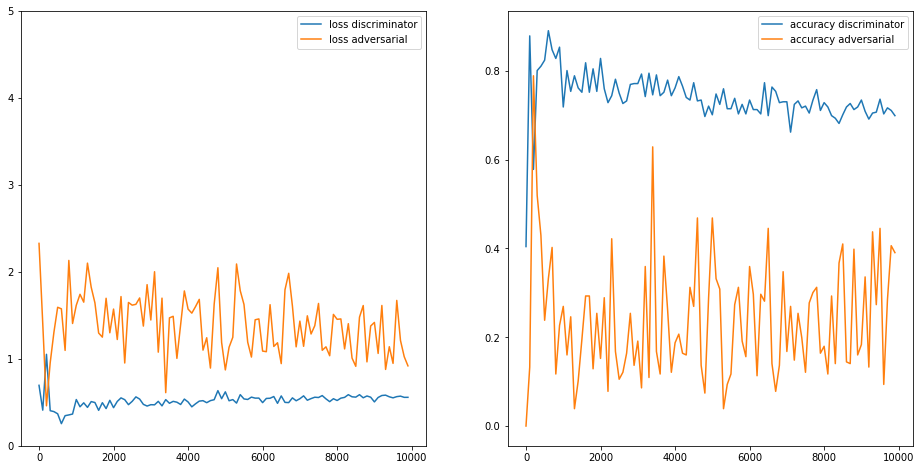

In [16]:
batch_size=256
plot_iteration=[]
loss_D = []
loss_A = []
acc_D = []
acc_A = []
vis_noise = np.random.random(size=[16, 100])
for i in range(10000):
    real_batch = get_random_batch(x_train,batch_size=batch_size)
    noise_batch = get_random_batch(Z,batch_size=batch_size)
    fake_batch = net_G.predict(noise_batch)  #注意！！net_G此前虽然没有compile，也没有fit，
    #但是在模型定义之后(具体而言是每次调用model.add()之后),参数就已经初始化过了。
    mix_batch = np.concatenate((real_batch,fake_batch)) #注意内部括号。否则报错：only integer scalar arrays can be converted to a scalar index
    label = np.ones((2*batch_size,1))
    label[batch_size:,0]=0
    #在每个batch上对判别器进行训练
    D_state = model_D.train_on_batch(mix_batch,label) #model.train_on_batch函数返回两个值，第一个为loss，第二个为accuracy
    #在每个batch上对整个模型进行训练
    #定义model_A的target：全1label
    label = np.ones((batch_size,1))
    noise_batch = get_random_batch(Z,batch_size=batch_size)
    A_state = model_A.train_on_batch(noise_batch,label)
    if i % 100==0:
        plot_iteration.append(i)
        loss_D.append(D_state[0])
        loss_A.append(A_state[0])
        acc_D.append(D_state[1])
        acc_A.append(A_state[1])
        clear_output(wait=True)
        fig,(ax1,ax2) = plt.subplots(1,2)
        fig.set_size_inches(16,8)
        
        ax1.plot(plot_iteration,loss_D,label='loss discriminator')
        ax1.plot(plot_iteration,loss_A,label='loss adversarial')
        ax1.set_ylim([0,5])
        ax1.legend()
        
        ax2.plot(plot_iteration,acc_D,label='accuracy discriminator')
        ax2.plot(plot_iteration,acc_A,label='accuracy adversarial')
        ax2.legend()
        
        plt.show()

        images = net_G.predict(vis_noise)
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [28, 28])
            
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(r'output/mnist_recon_GAN/{}.png'.format(i))
        plt.close('all')

对训练过程可视化：  
①使用imageio将multi image转为gif！！  
②使用Ipython.display.Image(url=file_location)将本地的图像展示在notebook上

In [27]:
import imageio 
from IPython.display import Image
filenames = [r'output/mnist_recon_GAN/{}.png'.format(i*500) for i in range(20)]
images=[]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(r'output/mnist_recon_GAN/generating_digits.gif',images,duration=0.5)
Image(url='output/mnist_recon_GAN/generating_digits.gif')

### Play with vector z

实验室之二：笑容逐渐消失

In [39]:
z1 = np.random.random((1,100))
z2 = np.random.random((1,100))

In [75]:
def plot_generated_image(z):
    g=np.squeeze(net_G.predict(z))
    confidence = model_A.predict(z)
    plt.imshow(g,cmap='gray')
    plt.xlabel('confidence:{:.3f}'.format(confidence[0][0]))

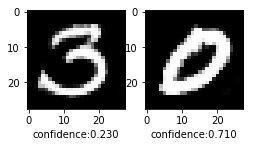

In [76]:
plt.subplot(131)
plot_generated_image(z1)
plt.subplot(132)
plot_generated_image(z2)

<IPython.core.display.Javascript object>


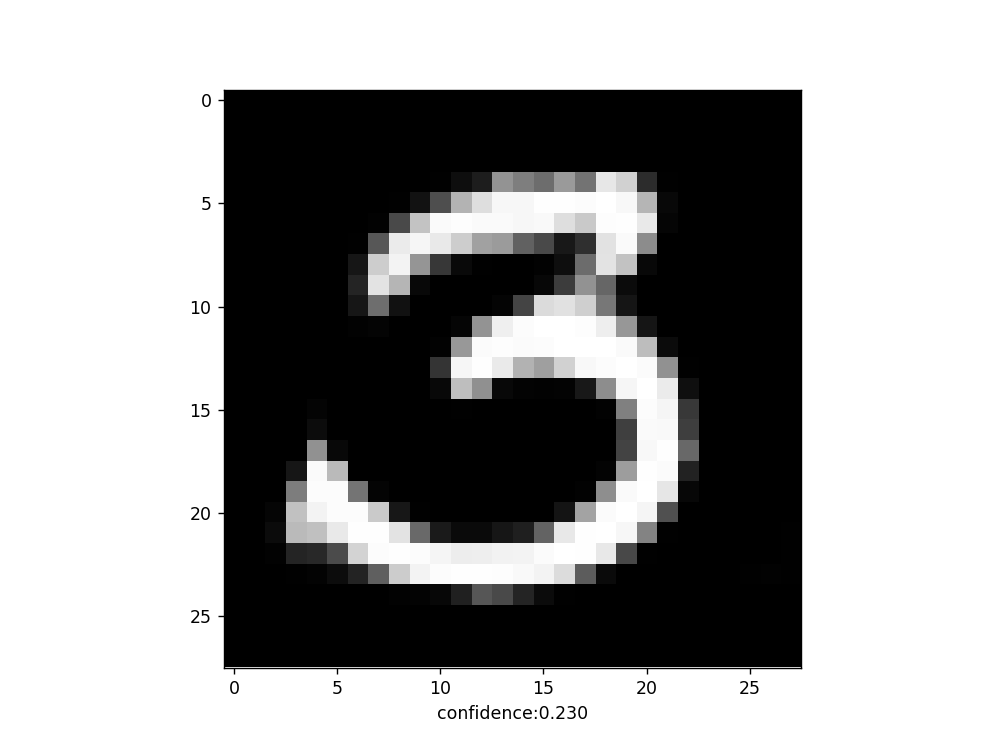

In [77]:
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
for w in np.linspace(0,1,50):
    fig.clf()
    z3 = w*z1+(1-w)*z2
    plot_generated_image(z3)
    fig.canvas.draw()
#     plt.pause(0.2)
    

实验室之三：随机产生图像：

<IPython.core.display.Javascript object>


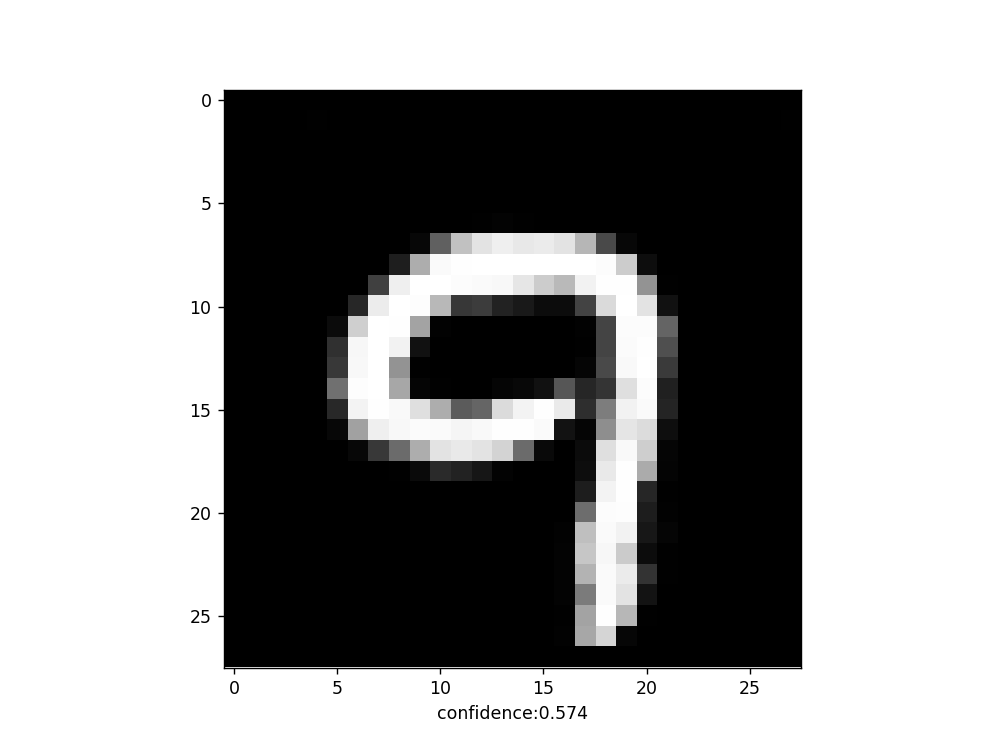

In [79]:
fig = plt.figure(figsize=(8,6))
for i in range(30):
    fig.clf()
    z = np.random.random((1,100))
    plot_generated_image(z)
    fig.canvas.draw()
    plt.pause(0.1)

In [54]:
net_G.save('models_saved/GAN/mnist_generator.keras')
net_D.save('models_saved/GAN/mnist_discriminator.keras')
model_A.save('models_saved/GAN/model_A.keras')
model_D.save('models_saved/GAN/model_D.keras')

In [57]:
w1_trained = model_D.layers[-1].get_weights()

In [64]:
model_A.predict(z2)

array([[0.70992625]], dtype=float32)

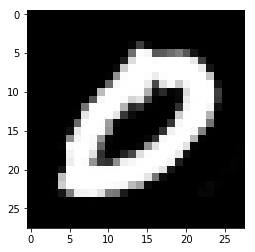

In [66]:
%matplotlib inline
plot_generated_image(z2)